# Introduction to CT

In this exercise sheet we will get to know the Computed Tomography reconstruction problem

## Load Data

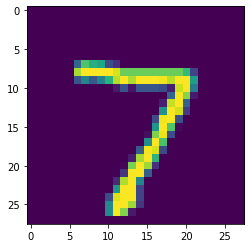

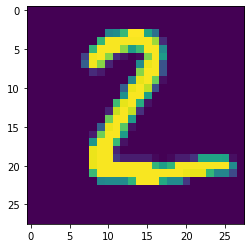

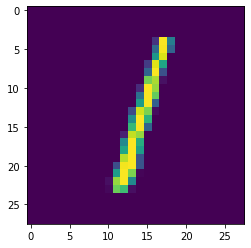

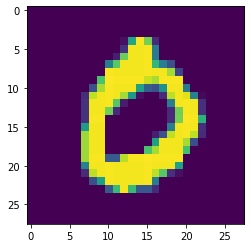

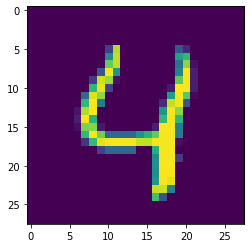

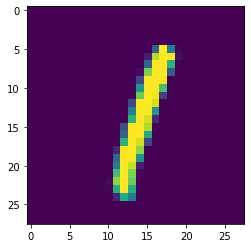

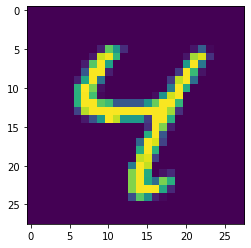

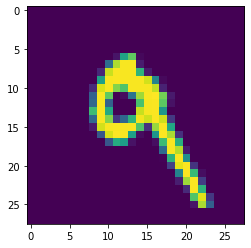

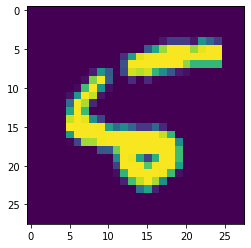

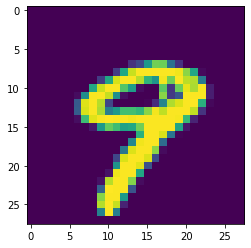

In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
%matplotlib inline

batch_size = 10

# datasets (MNIST)
transform_test = transforms.Compose([
    transforms.ToTensor()
])
mnist_test = datasets.MNIST('/data', train=False, download=True, transform=transform_test)

# dataloaders
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

batch, labels = next(iter(test_loader))

phantoms = [batch[i][0].numpy() for i in range(batch_size)]


##########################################
# TODO: show first phantom
for i in range(batch_size):
    plt.imshow(phantoms[i])
    plt.show()
##########################################

## Computed Tomography

In computed tomography, the tomography reconstruction problem is to obtain a tomographic slice image from a set of projections 1. A projection is formed by drawing a set of parallel rays through the 2D object of interest, assigning the integral of the object’s contrast along each ray to a single pixel in the projection. A single projection of a 2D object is one dimensional. To enable computed tomography reconstruction of the object, several projections must be acquired, each of them corresponding to a different angle between the rays with respect to the object. A collection of projections at several angles is called a sinogram, which is a linear transform of the original image.

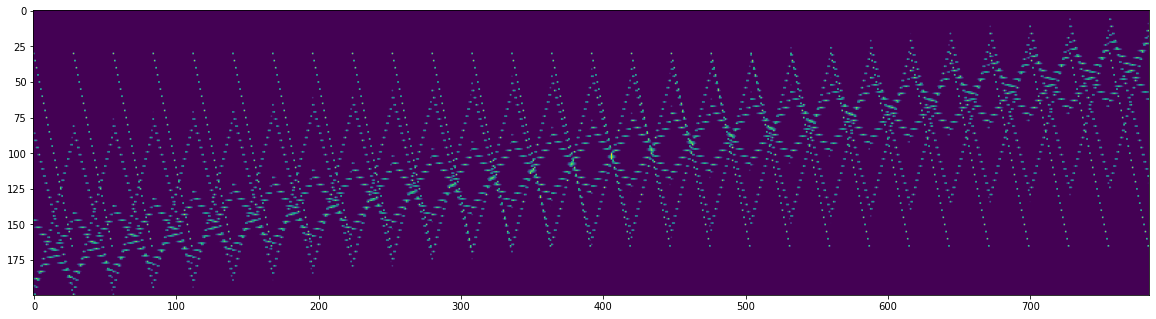

In [30]:
import numpy as np
from skimage.transform import radon

n, m = 28, 28

##########################################
# TODO: specify number of angles!
angles = 5
##########################################

detectors = 40

##########################################
# TODO: create operator matrix filled with zeros
operator = np.zeros((angles * detectors, n * m))
##########################################

theta = np.linspace(0.0, 180.0, angles, endpoint=False)

for i in range(n * m):
    unit = np.zeros(n * m)
    unit[i] = 1
    operator[:, i] = radon(unit.reshape(n, m), theta, circle=False).reshape(-1)

plt.figure(figsize=(20, 20))
plt.imshow(operator)

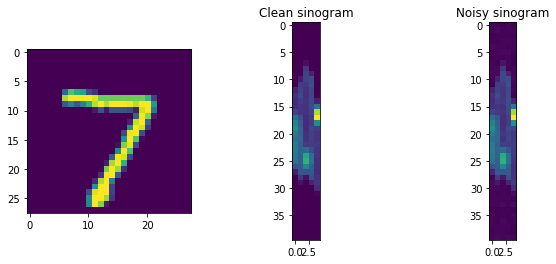

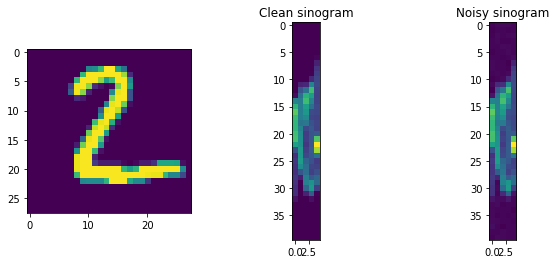

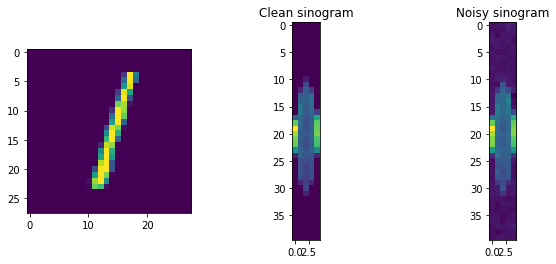

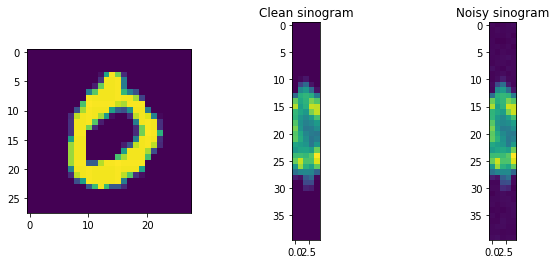

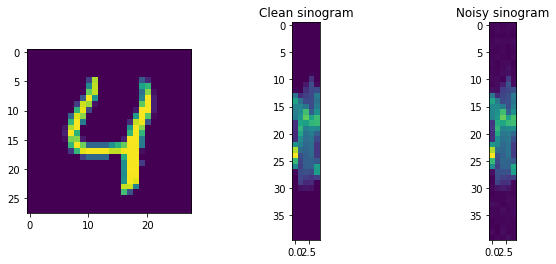

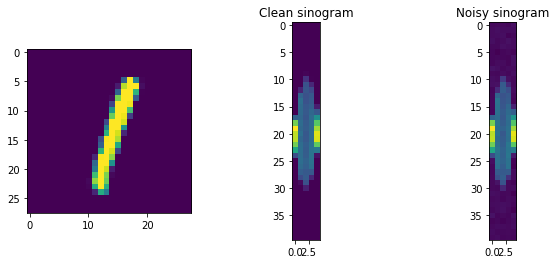

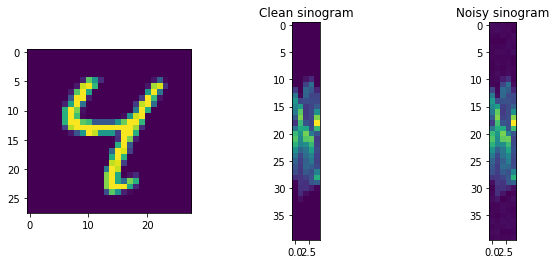

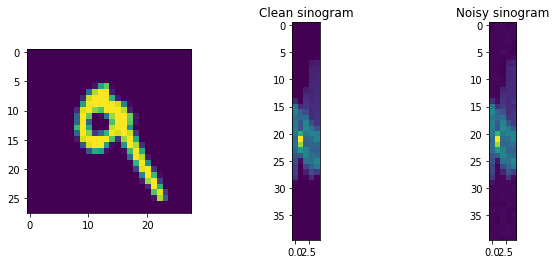

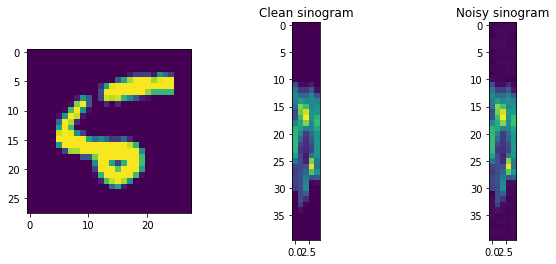

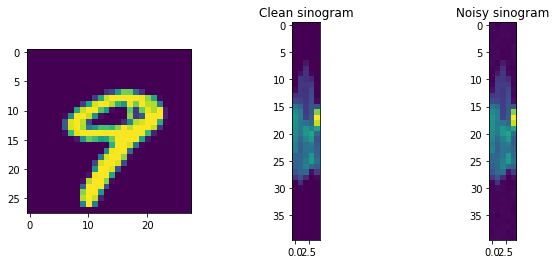

In [32]:
sinograms = []
for phantom in phantoms:
    plt.figure(figsize=(10, 4))

    # clean image
    plt.subplot(1, 3, 1)
    plt.imshow(phantom)

    # clean sinogram
    
    ##########################################
    # TODO: multiply operator matrix with phantom to get sinogram
    sinogram = np.matmul(operator, phantom.reshape(-1))
    sinogram = sinogram.reshape(detectors, angles)
    ##########################################
    
    plt.subplot(1, 3, 2)
    plt.title('Clean sinogram')
    plt.imshow(sinogram)

    # noisy sinogram
    plt.subplot(1, 3, 3)
    
    ##########################################
    # TODO: add noise to the sinogram
    sinogram += 0.1 * np.random.normal(size=sinogram.shape)
    ##########################################
    
    sinograms.append(sinogram)
    plt.title('Noisy sinogram')
    plt.imshow(sinogram)

# Direct Inverse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


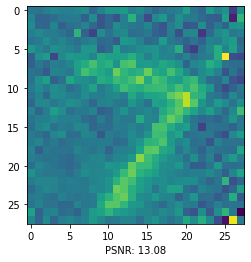

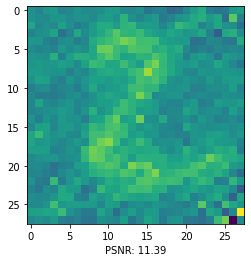

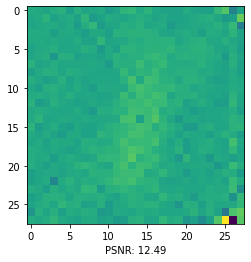

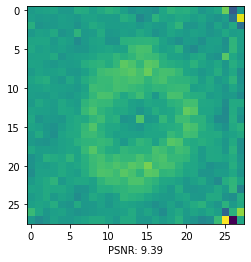

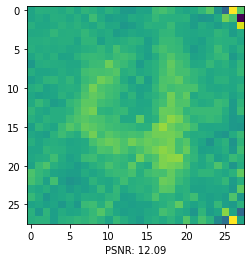

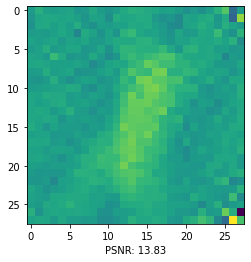

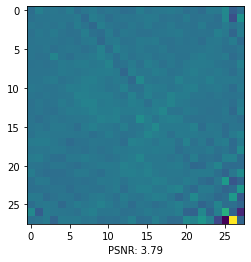

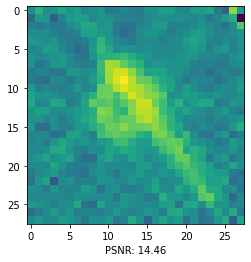

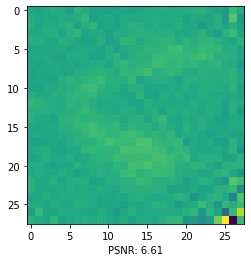

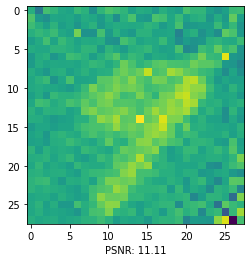

In [34]:
from skimage.measure import compare_psnr


plt.figure(figsize=(15, 4))

inv_operator = np.linalg.pinv(operator)

for i, phantom in enumerate(phantoms):
    # plt.subplot(1, len(phantoms), i+1)
    
    ##########################################
    # TODO: compute direct inverse by inverting the matrix
    x_rec = np.matmul(inv_operator, sinograms[i].reshape(-1)).reshape(n, m)
    ##########################################
    
    plt.xlabel('PSNR: %.2f' % compare_psnr(phantom, x_rec))
    plt.imshow(x_rec)
    plt.show()

# Filtered Back Projection

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.7/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


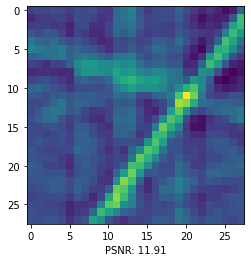

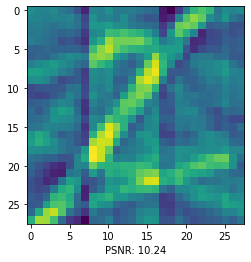

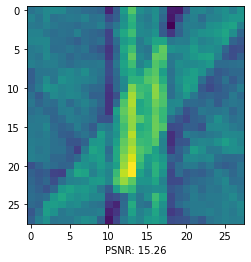

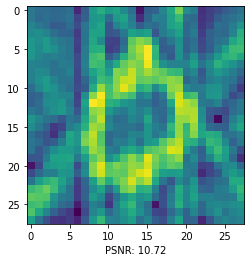

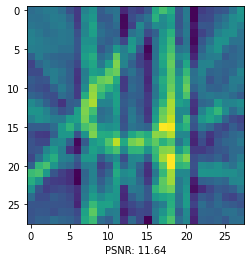

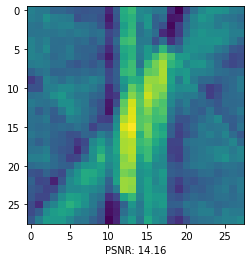

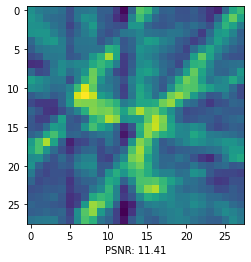

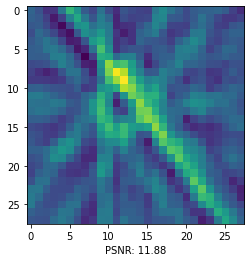

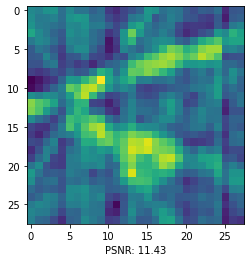

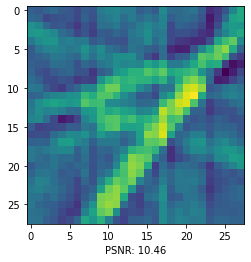

In [37]:
from skimage.transform import iradon

plt.figure(figsize=(15, 4))

for i, phantom in enumerate(phantoms):
    # plt.subplot(1, len(phantoms), i+1)
    x_rec = iradon(sinograms[i], theta, circle=False)
    plt.xlabel('PSNR: %.2f' % compare_psnr(phantom, x_rec))
    plt.imshow(x_rec)
    plt.show()

# TSVD

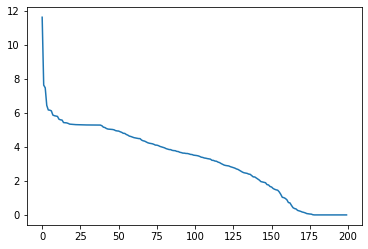

In [38]:
##########################################
# TODO: Compute SVD of the operator and plot the singular values
U, S, V = np.linalg.svd(operator)

plt.plot(S)
##########################################

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/skimage/measure/simple_metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return peak_signal_noise_ratio(im_true, im_test, data_range=data_range)


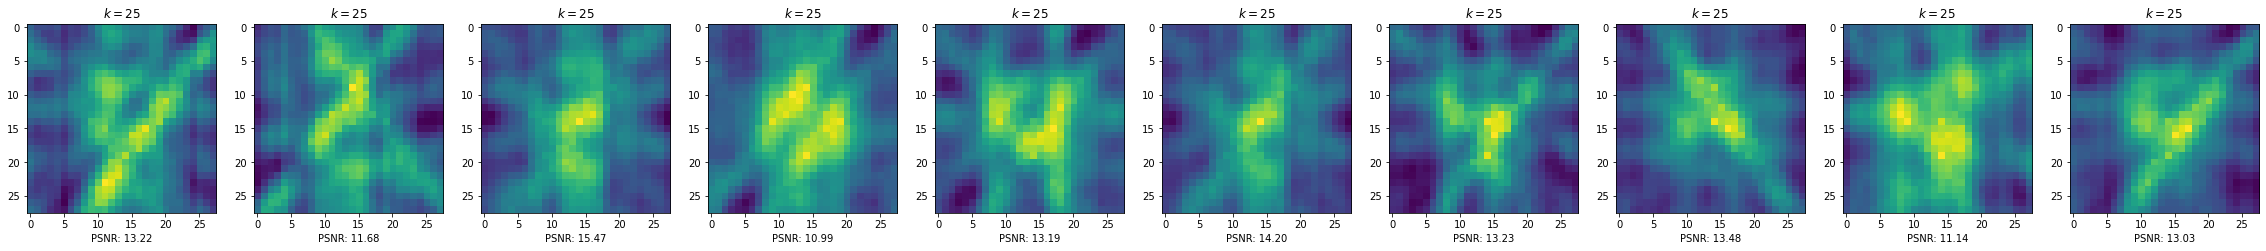

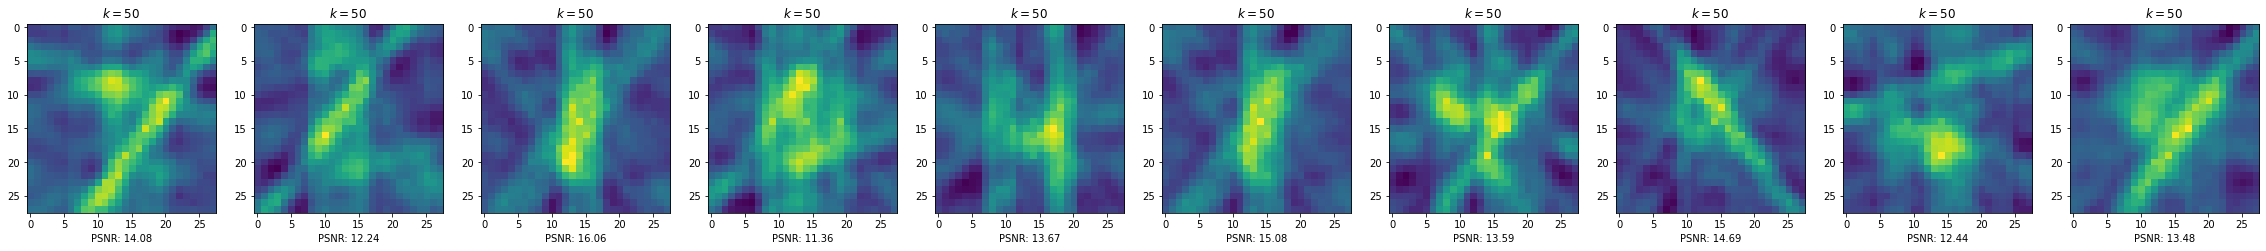

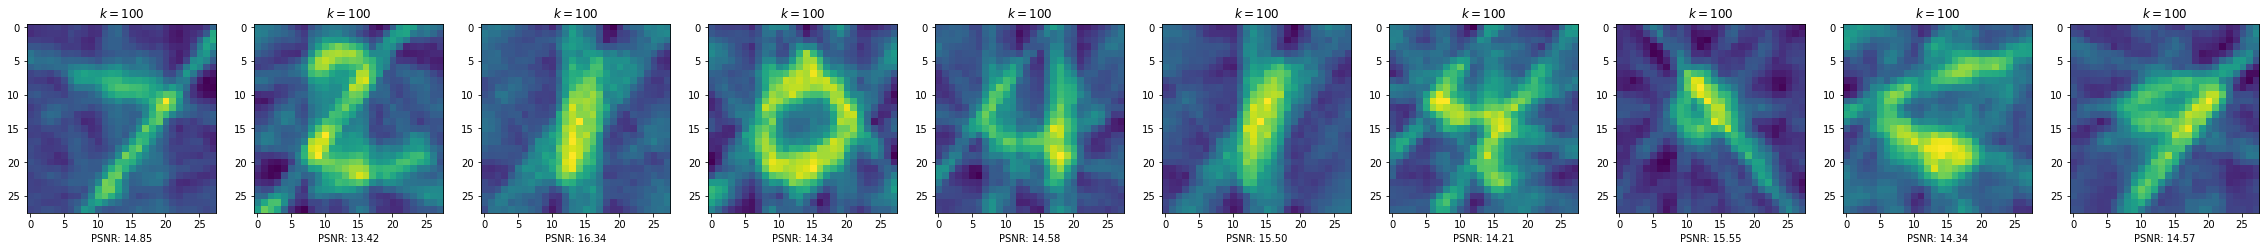

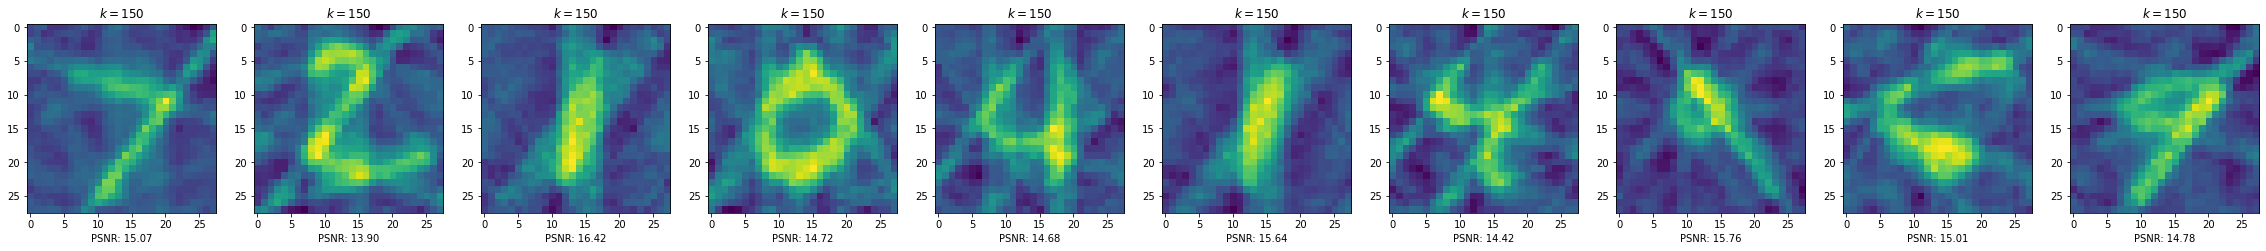

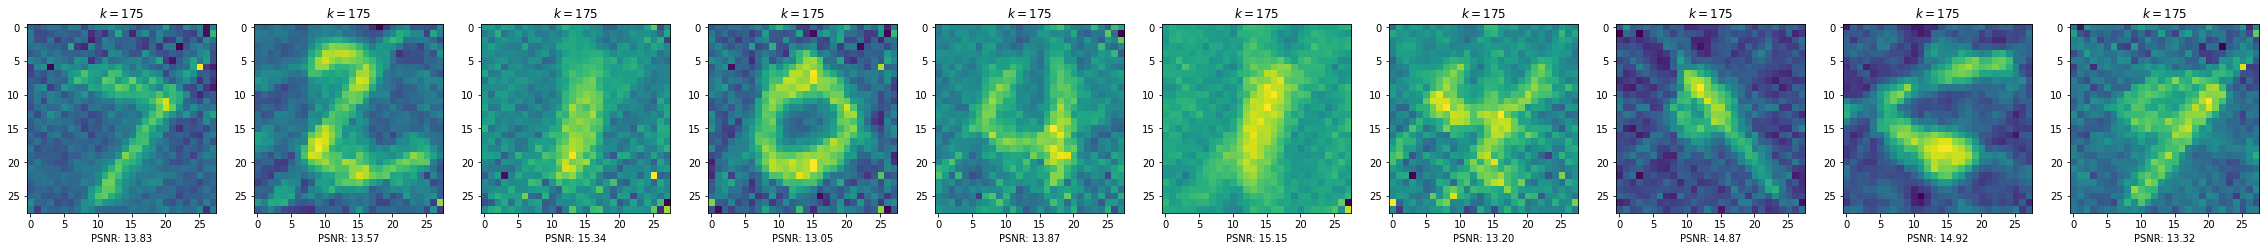

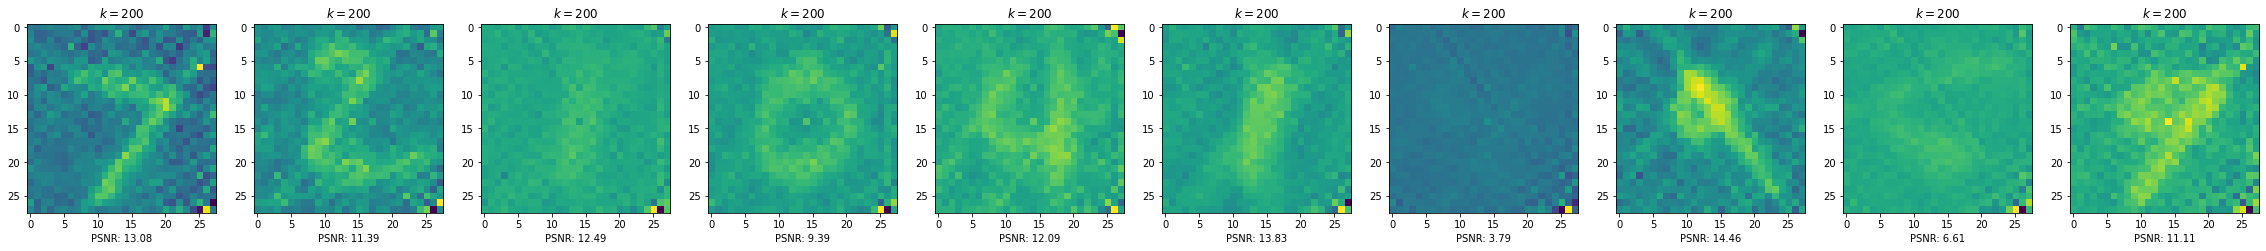

In [42]:
def truncated_svd(U, S, V, y, k):
    S_inv = []
    sigma = np.zeros((V.shape[0], U.shape[0]))
    
    for i in range(len(S)):
        if i < k and S[i] > 1e-9:
            sigma[i,i] = 1/S[i]
        else:
            sigma[i,i] = 0
    
    A_inv = np.dot(np.dot(V.T, sigma), U.T)
    return np.dot(A_inv, y)


for k in [len(S)//8, len(S)//4, len(S)//2, 3*len(S)//4, 7*len(S)//8, len(S)]:
    plt.figure(figsize=(40, 40))   

    for i, phantom in enumerate(phantoms):
        plt.subplot(1, len(phantoms), i+1)
        x_rec = truncated_svd(U, S, V, sinograms[i].reshape(-1), k).reshape(n,m)
        plt.title(r'$k=%d$' % k)
        plt.xlabel('PSNR: %.2f' % compare_psnr(phantom, x_rec))
        plt.imshow(x_rec)
     
    plt.show()